In [8]:
import sys
sys.path.append("/home/flora/Documents/EnsemblePursuit")
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import matplotlib.pyplot as plt

In [2]:
def fit(data_path):
    dt=1
    spks= np.load(data_path+'spks.npy')
    print('Shape of the data matrix, neurons by timepoints:',spks.shape)
    iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
    ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
    iframe = iframe[ivalid]
    S = spks[:, iframe+dt]
    print(S.shape)
    ep=EnsemblePursuit(n_components=200,lam=0.01,n_kmeans=200)
    model=ep.fit(S.T)
    V=model.components_
    U=model.weights
    return U,V
    
U,V=fit('/home/flora/Documents/')

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)
obtained 200 PCs in 15.6661 seconds
initialized 200 clusters with k-means in 110.3903 seconds
ensemble 0, time 33.55, nr neurons 5260, EV 0.0070
ensemble 25, time 281.01, nr neurons 200, EV 0.0274
ensemble 50, time 451.73, nr neurons 96, EV 0.0356
ensemble 75, time 591.44, nr neurons 65, EV 0.0417
ensemble 100, time 713.44, nr neurons 47, EV 0.0469
ensemble 125, time 819.61, nr neurons 44, EV 0.0514
ensemble 150, time 912.52, nr neurons 34, EV 0.0552
ensemble 175, time 995.64, nr neurons 32, EV 0.0586
ensemble 199, time 1067.78, nr neurons 27, EV 0.0616
average sparsity is 0.0081


30560


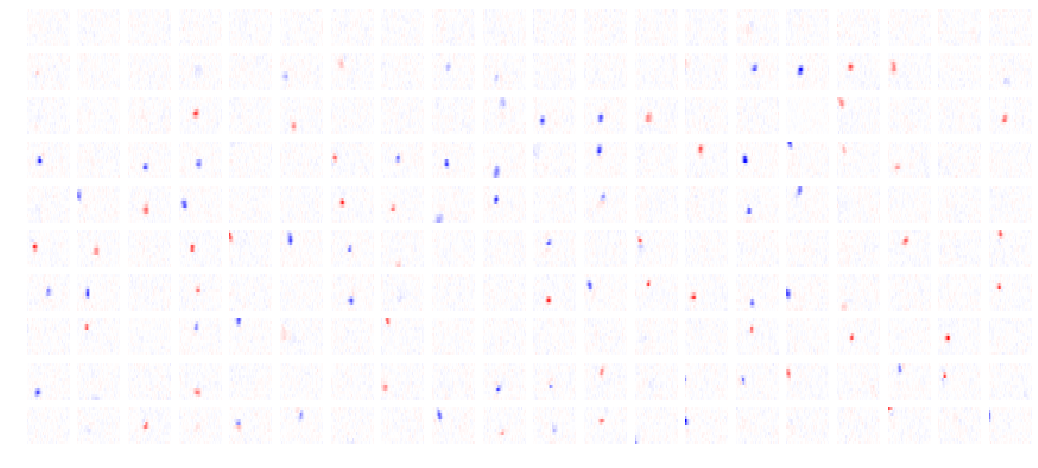

[0.99391253 0.99363979 0.99357754 0.98898079 0.99371582 0.99358501
 0.99208183 0.99361544 0.991088   0.99366098 0.99089953 0.99346458
 0.99175577 0.99246532 0.98866535 0.9942606  0.98074426 0.99329264
 0.99270975 0.99324417 0.98922028 0.99608154 0.99266365 0.98858473
 0.97767409 0.97993077 0.97845793 0.9936687  0.98037588 0.98524782
 0.99305644 0.99242096 0.99433774 0.98706702 0.92003346 0.85890525
 0.92247076 0.93414155 0.99466874 0.98716927 0.99088496 0.99717876
 0.99146343 0.91266662 0.99415587 0.96164878 0.99335638 0.9915759
 0.99113087 0.970901   0.92316132 0.91353454 0.93718298 0.99219367
 0.98877647 0.99919019 0.94021022 0.99247034 0.9934524  0.94554109
 0.90094401 0.99305838 0.93325271 0.93488331 0.99176585 0.99454155
 0.95355011 0.95503769 0.92737897 0.92234818 0.98818791 0.88564184
 0.99382117 0.92273294 0.84805675 0.91780557 0.98133118 0.97214357
 0.99087197 0.99520874 0.99268957 0.94522639 0.92124061 0.91453997
 0.99287769 0.99288563 0.92306206 0.9595972  0.95821316 0.90521

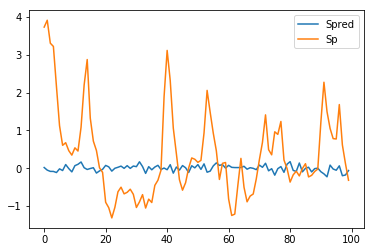

In [13]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest
def fit_receptive_field_on_minus_off(V,data_path):
        spks= np.load(data_path+'spks.npy')
        iframe = np.load(data_path+'iframe.npy')
        mov    = np.load(data_path+'mov.npy')# these are the visual stimuli shown
        dt = 1 # time offset between stimulus presentation and response
        ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
        iframe = iframe[ivalid]
        mov = mov[:, :, ivalid]
        Sp = V.T
        Sp = zscore(Sp, axis=1)
        ly, lx, nstim = mov.shape
        del spks
        NT = Sp.shape[1]
        NN=Sp.shape[0]
        print(NT)
        itrain,itest=train_test_split(NT)

        X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
        X = X-0.5 # subtract the background
        #X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
        X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
        npix = X.shape[0]

        lam = 0.1
        ncomps = Sp.shape[0]
        B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ Sp[:,itrain].T)) # get the receptive fields for each neuron

        B0 = np.reshape(B0, (ly, lx, ncomps))
        B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

        plt.figure(figsize=(18, 8))
        rfmax = np.max(B0)
        for j in range(200):
            plt.subplot(10,20,j+1)
            rf = B0[:,:,j]
            # rfmax = np.max(np.abs(rf))
            plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
            #plt.title('PC %d'%(1+j))
            plt.axis('off')

        plt.show()

        Spred = np.reshape(B0, (-1,NN)).T @ X[:,itest]
        varexp = 1.0 - Spred.var(axis=1)/Sp[:,itest].var(axis=1)
        print(varexp)
        print(Spred.shape)
        print(Sp.shape)
        original=Sp[:,itest]
        print(original.shape)
        plt.plot(Spred[0,:100],label='Spred')
        plt.plot(original[0,:100],label='Sp')
        plt.legend()
        corr_lst=[]
        for j in range(0,200):
            corr_lst.append(np.corrcoef(Sp[j,itest],Spred[j,:])[0,1])
        print(corr_lst)
        return B0,corr_lst
B0,corr_lst=fit_receptive_field_on_minus_off(V,'/home/flora/Documents/')

In [12]:
def fit_to_behavior(V,data_path):
        iframe = np.load(data_path+'iframe.npy')
        spks= np.load(data_path+'spks.npy')
        dt = 1 # time offset between stimulus presentation and response
        ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
        iframe = iframe[ivalid]
        del spks
        proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
        motSVD = proc['motSVD'][:,iframe+dt]
        motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
        beh=motSVD
        NT = motSVD.shape[1]
        itrain,itest=train_test_split(NT)
        covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
        lam = 1e5 # regularizer
        covM += lam*np.eye(beh.shape[0])
        A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V.T[:,itrain].T))
        print(beh.shape)
        Vpred = np.matmul(A.T, beh[:,itest])
        print(Vpred.shape)
        varexp = 1 - ((Vpred - V.T[:,itest])**2).sum(axis=1)/(V.T[:,itest]**2).sum(axis=1)
        corr_lst=[]
        nr_of_components=V.shape[1]
        for j in range(0,nr_of_components):
            corr_lst.append(np.corrcoef(Vpred[j,:],V.T[j,itest])[0,1])
        return corr_lst

corr_lst_beh=fit_to_behavior(V,'/home/flora/Documents/')

(500, 30560)
(200, 7640)


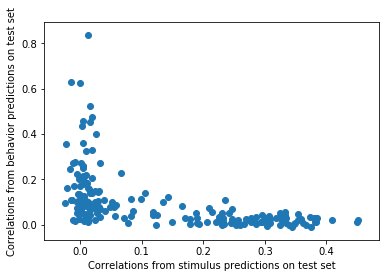

In [14]:
def selectivity_scatter_plot(corr_lst_stim,corr_lst_beh):
        plt.scatter(corr_lst_stim,corr_lst_beh)
        plt.xlabel('Correlations from stimulus predictions on test set')
        plt.ylabel('Correlations from behavior predictions on test set')
        plt.show()
selectivity_scatter_plot(corr_lst,corr_lst_beh)